In [1]:
import pandas as pd
from sqlalchemy import create_engine 
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def conecto():
    server = '157.92.26.17,1443'
    database = 'AdventureWorks2019'
    username = 'Alumno'
    password = 'mrcd2025'
    
    # Agregar username y password a la cadena de conexión
    connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    
    engine = create_engine(connection_string)
    return engine

engine = conecto()


## Retencion de clientes

In [4]:
### Por ahi una forma mas corta de hacer este roll back estaria bien
with engine.connect() as connection:
    trans = connection.begin()
    try:
        # Aquí iría tu código que podría fallar
        pass
    except Exception as e:
        trans.rollback()
        print("Se hizo rollback por error:", e)
    else:
        trans.commit()

##  Top productos mas consumidos 

,ProductName,TotalUnitsSold
0,AWC Logo Cap,8311
1,Water Bottle - 30 oz.,6815
2,"Sport-100 Helmet, Blue",6743
3,"Long-Sleeve Logo Jersey, L",6592
4,"Sport-100 Helmet, Black",6532
5,"Sport-100 Helmet, Red",6266
6,"Classic Vest, S",4247
7,Patch Kit/8 Patches,3865
8,"Short-Sleeve Classic Jersey, XL",3864
9,"Long-Sleeve Logo Jersey, M",3636


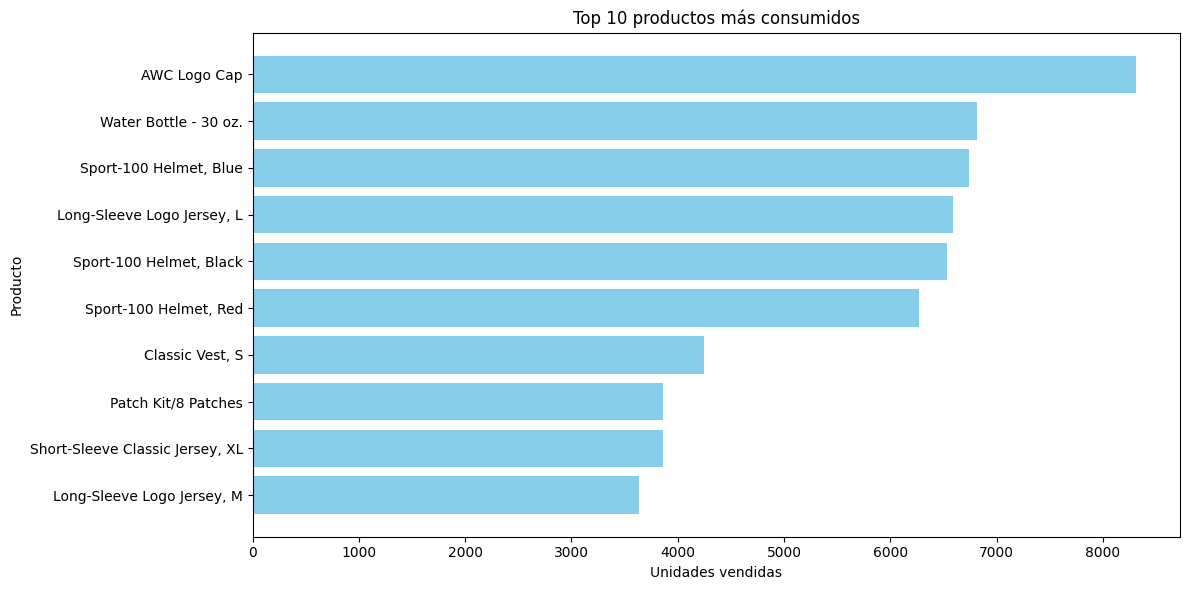

In [5]:
query= """ 
SELECT Top 10
    p.Name AS ProductName,
    SUM(sod.OrderQty) AS TotalUnitsSold
FROM Sales.SalesOrderDetail sod
    JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY TotalUnitsSold DESC;
    """
productos_mas_vendidos = pd.read_sql(query, engine)
display(productos_mas_vendidos)

#Grafico de barras 
plt.figure(figsize=(12,6))
plt.barh(productos_mas_vendidos['ProductName'], productos_mas_vendidos['TotalUnitsSold'], color='skyblue')
plt.xlabel('Unidades vendidas')
plt.ylabel('Producto')
plt.title('Top 10 productos más consumidos')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

## Ventas 

,Año,Ventas_totales
0,2011,14155699.53
1,2012,37675700.31
2,2013,48965887.96
3,2014,22419498.32


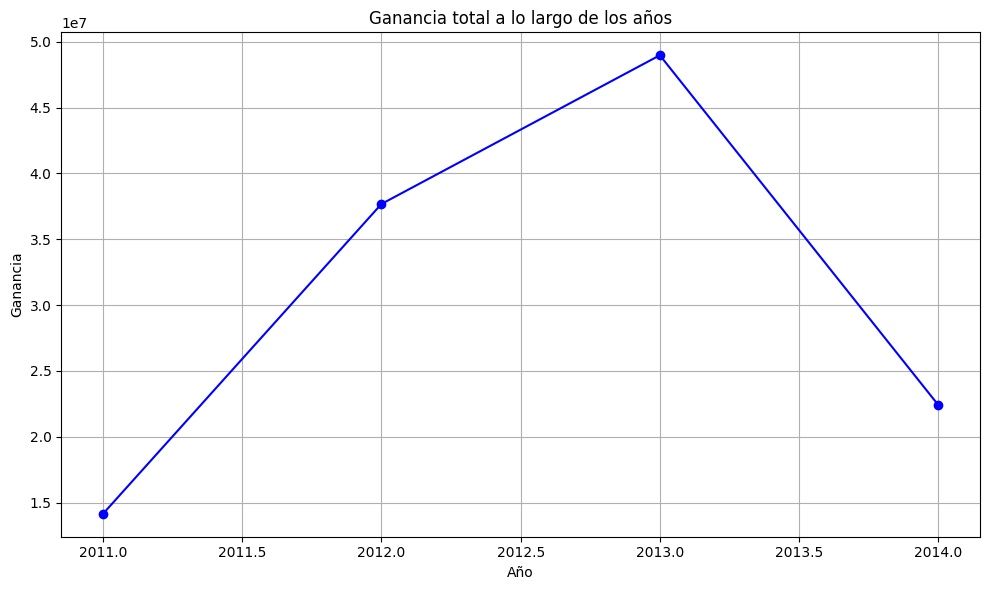

In [6]:
query = """
SELECT
    YEAR(OrderDate) AS Año,
    ROUND(SUM(TotalDue), 2) AS Ventas_totales
FROM  Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY Año ASC;
"""

ventas_por_año = pd.read_sql(query, engine)
display(ventas_por_año)

plt.figure(figsize=(10,6))
plt.plot(ventas_por_año['Año'], ventas_por_año['Ventas_totales'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Ganancia')
plt.title('Ganancia total a lo largo de los años')
plt.grid(True)
plt.tight_layout()
plt.show()

## Rentabilidad de los territorios a lo largo de los años

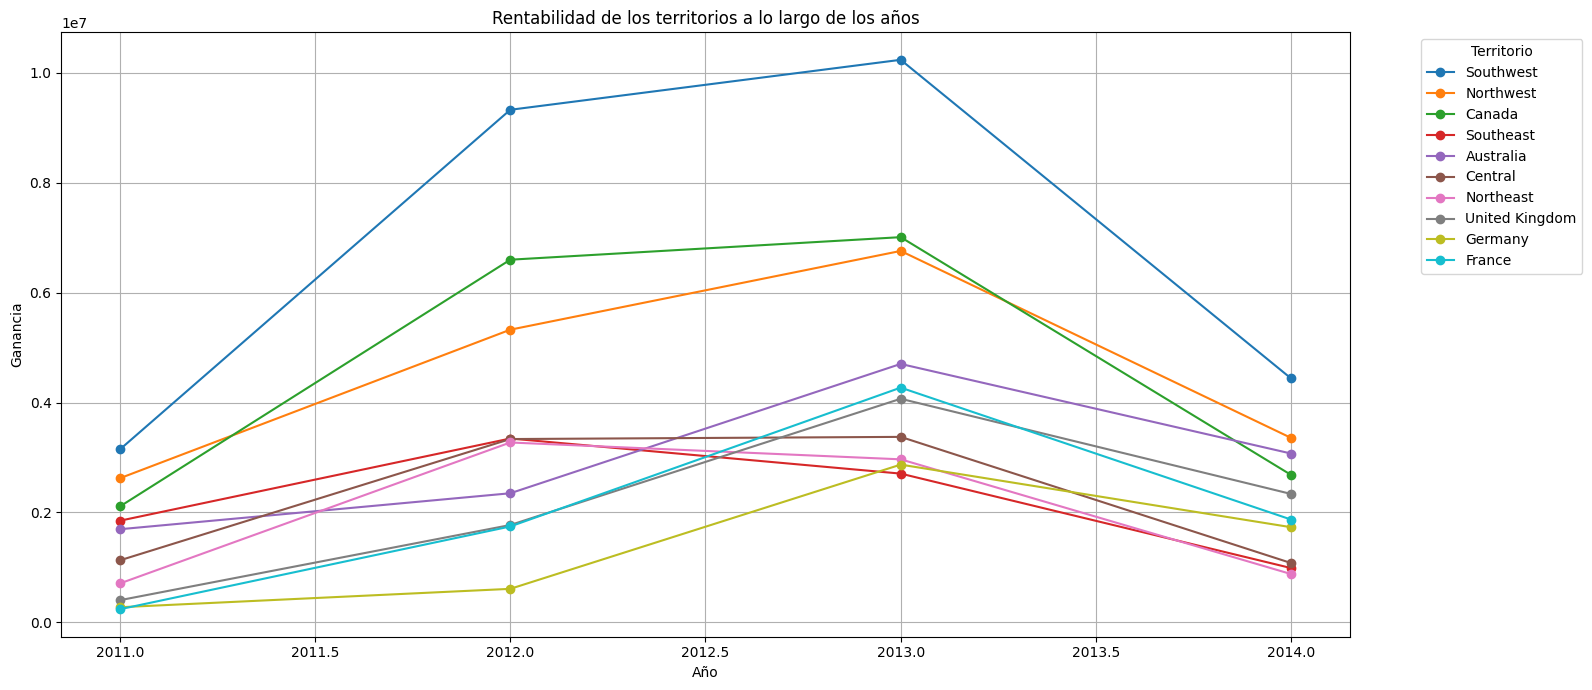

In [7]:
# Consulta modificada para mostrar la rentabilidad de los territorios a lo largo de los años
query = """
SELECT
    YEAR(soh.OrderDate) AS Año,
    st.Name AS Territorio,
    SUM(soh.TotalDue) AS Ventas_totales
FROM Sales.SalesOrderHeader soh
    JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY YEAR(soh.OrderDate), st.Name
ORDER BY Año ASC, Ventas_totales DESC;
"""
territorios_ventas_anio = pd.read_sql(query, engine)

# Gráfico de la rentabilidad de los territorios a lo largo de los años
plt.figure(figsize=(16,7))
for territorio in territorios_ventas_anio['Territorio'].unique():
    datos_territorio = territorios_ventas_anio[territorios_ventas_anio['Territorio'] == territorio]
    plt.plot(datos_territorio['Año'], datos_territorio['Ventas_totales'], marker='o', label=territorio)

plt.xlabel('Año')
plt.ylabel('Ganancia')
plt.title('Rentabilidad de los territorios a lo largo de los años')
plt.legend(title='Territorio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# Ultimo

## Ganancia a lo largo de los meses

,Año,Mes,Mes_nombre,Ventas_totales
0,2011,5,May,567020.95
1,2011,6,June,507096.47
2,2011,7,July,2292182.88
3,2011,8,August,2800576.17
4,2011,9,September,554791.61
5,2011,10,October,5156269.53
6,2011,11,November,815313.02
7,2011,12,December,1462448.90
8,2012,1,January,4458337.44
9,2012,2,February,1649051.90


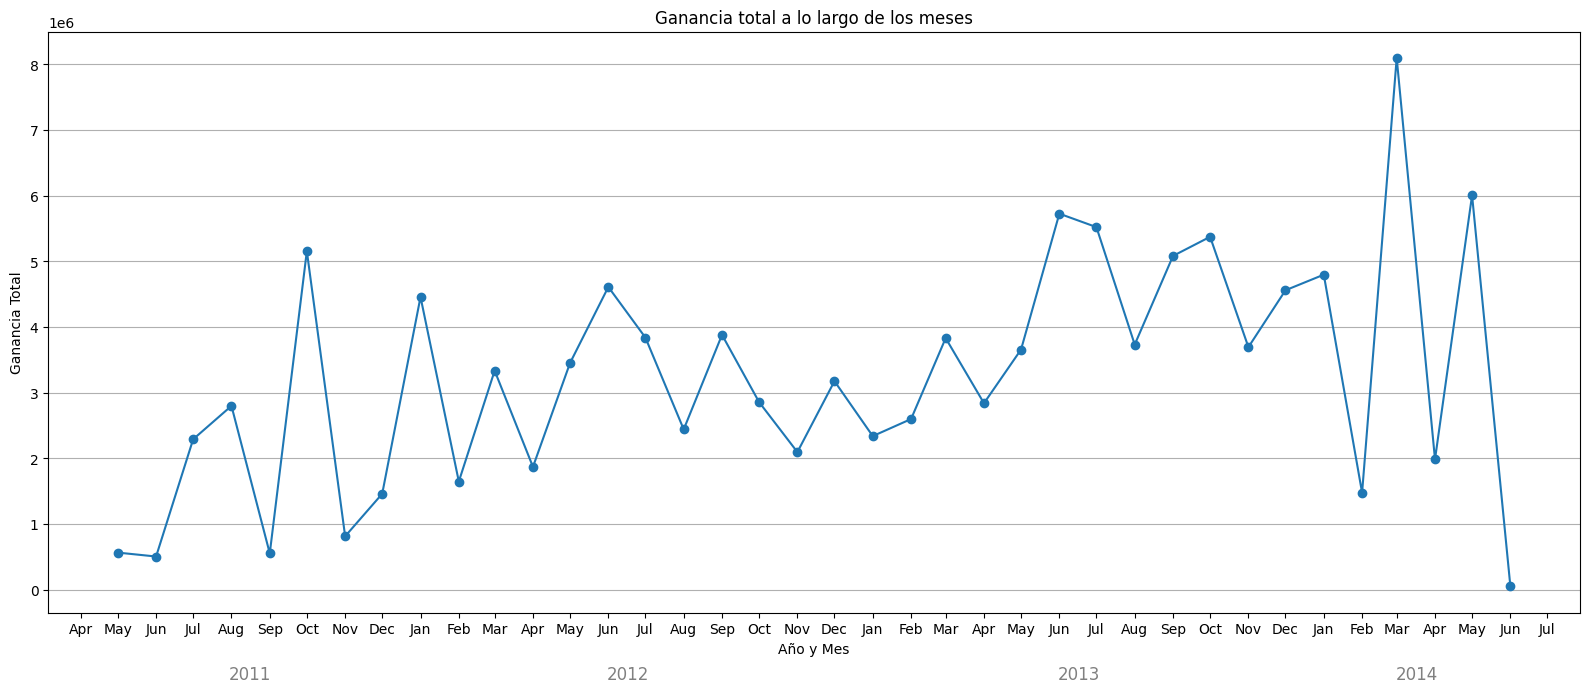

In [9]:
query = """
SELECT
    YEAR(OrderDate) AS Año,
    MONTH(OrderDate) AS Mes,
    DATENAME(MONTH, OrderDate) AS Mes_nombre,
    ROUND(SUM(TotalDue), 2) AS Ventas_totales
FROM
    Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate), DATENAME(MONTH, OrderDate)
ORDER BY Año ASC, Mes ASC;
"""

ventas_por_anio_mes = pd.read_sql(query, engine)
display(ventas_por_anio_mes)

# Crear una columna de fecha para el eje X
ventas_por_anio_mes['Fecha'] = pd.to_datetime(
    ventas_por_anio_mes['Año'].astype(str) + '-' + ventas_por_anio_mes['Mes'].astype(str) + '-01'
)

plt.figure(figsize=(16,7))
plt.plot(ventas_por_anio_mes['Fecha'], ventas_por_anio_mes['Ventas_totales'], marker='o', color='tab:blue')

plt.xlabel('Año y Mes')
plt.ylabel('Ganancia Total')
plt.title('Ganancia total a lo largo de los meses')

# Personalizar el eje X para mostrar llaves por año y puntos por mes
import matplotlib.dates as mdates

ax = plt.gca()
# Mostrar ticks mensuales
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Añadir llaves para los años
years = ventas_por_anio_mes['Año'].unique()
for year in years:
    # Encontrar el primer y último mes de cada año
    fechas_anio = ventas_por_anio_mes[ventas_por_anio_mes['Año'] == year]['Fecha']
    if not fechas_anio.empty:
        x0 = fechas_anio.min()
        x1 = fechas_anio.max()
        y_min, y_max = ax.get_ylim()
        # Dibujar una llave (línea horizontal con corchetes) debajo del eje X
        ax.annotate(
            '', 
            xy=(x0, y_min - (y_max-y_min)*0.05), 
            xytext=(x1, y_min - (y_max-y_min)*0.05),
            arrowprops=dict(arrowstyle='-[,widthB=8.0,lengthB=1.0', lw=2, color='gray')
        )
        # Etiqueta del año centrada
        ax.text(
            x0 + (x1 - x0)/2, 
            y_min - (y_max-y_min)*0.09, 
            str(year), 
            ha='center', va='top', fontsize=12, color='gray'
        )

plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

## Ventas a lo largo de los meses teniendo en cuenta los territorios

,Año,Mes,MonthName,Territorio,Ventas_totales
0,2011,5,May,Australia,3756.99
1,2011,5,May,Canada,133887.76
2,2011,5,May,Central,21664.31
3,2011,5,May,France,3756.99
4,2011,5,May,Northeast,24319.79
...,...,...,...,...,...
359,2014,6,June,Germany,3818.44
360,2014,6,June,Northwest,10665.59
361,2014,6,June,Southeast,125.93
362,2014,6,June,Southwest,9842.42


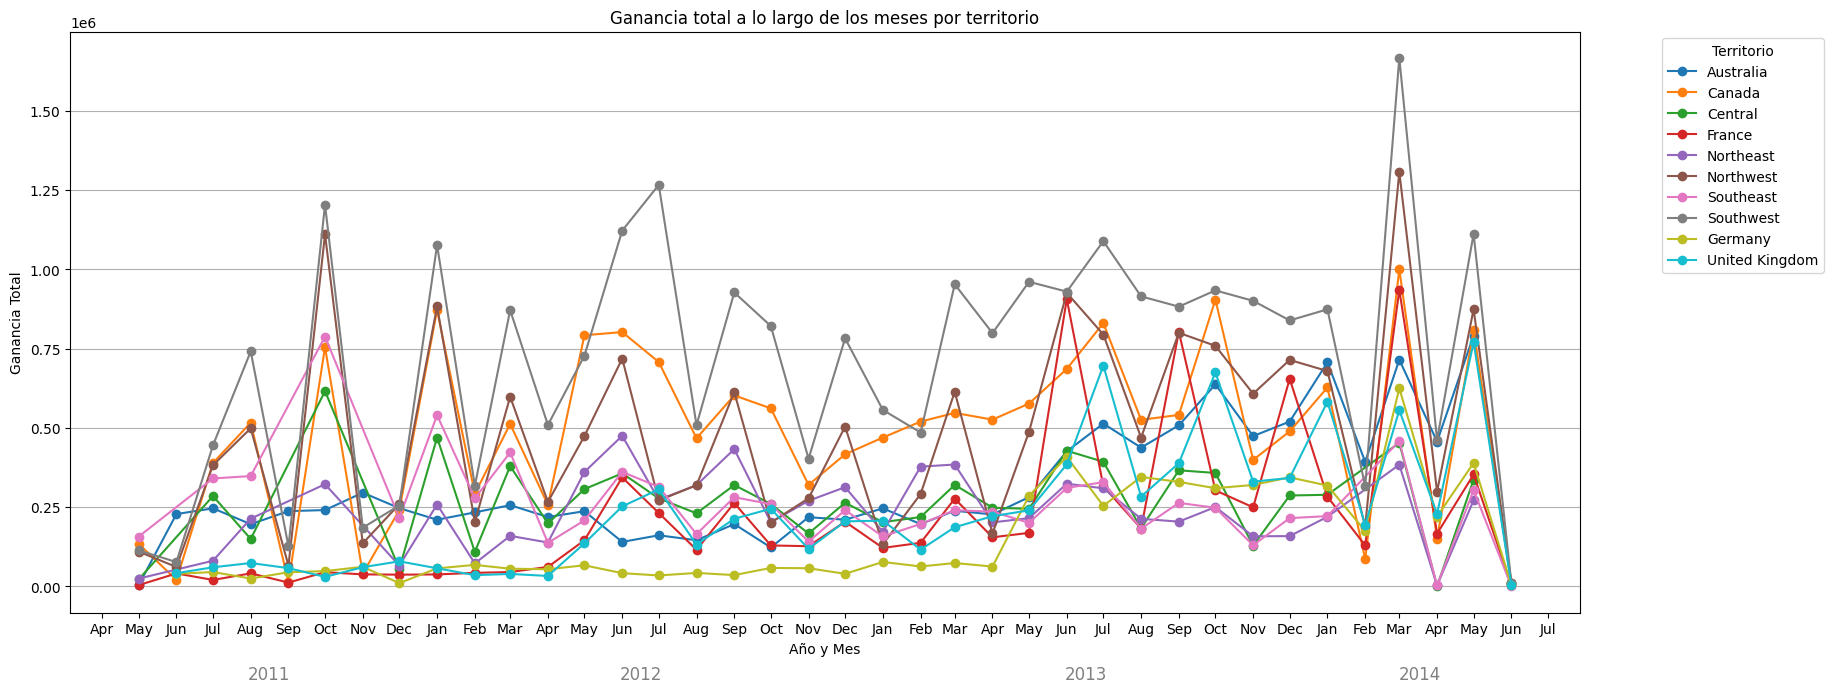

In [11]:
query = """
SELECT
    YEAR(soh.OrderDate) AS Año,
    MONTH(soh.OrderDate) AS Mes,
    DATENAME(MONTH, soh.OrderDate) AS MonthName,
    st.Name AS Territorio,
    ROUND(SUM(soh.TotalDue), 2) AS Ventas_totales
FROM
    Sales.SalesOrderHeader soh
    LEFT JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY YEAR(soh.OrderDate), MONTH(soh.OrderDate), DATENAME(MONTH, soh.OrderDate), st.Name
ORDER BY Año ASC, Mes ASC, Territorio ASC;
"""

ventas_por_anio_mes_territorio = pd.read_sql(query, engine)
display(ventas_por_anio_mes_territorio)

# Crear una columna de fecha para el eje X
ventas_por_anio_mes_territorio['Fecha'] = pd.to_datetime(
    ventas_por_anio_mes_territorio['Año'].astype(str) + '-' + ventas_por_anio_mes_territorio['Mes'].astype(str) + '-01'
)

plt.figure(figsize=(16,7))

# Graficar una línea por territorio
territorios = ventas_por_anio_mes_territorio['Territorio'].unique()
for territorio in territorios:
    datos_territorio = ventas_por_anio_mes_territorio[ventas_por_anio_mes_territorio['Territorio'] == territorio]
    plt.plot(
        datos_territorio['Fecha'],
        datos_territorio['Ventas_totales'],
        marker='o',
        label=territorio
    )

plt.xlabel('Año y Mes')
plt.ylabel('Ganancia Total')
plt.title('Ganancia total a lo largo de los meses por territorio')

# Personalizar el eje X para mostrar llaves por año y puntos por mes
import matplotlib.dates as mdates

ax = plt.gca()
# Mostrar ticks mensuales
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Añadir llaves para los años
years = ventas_por_anio_mes_territorio['Año'].unique()
for year in years:
    fechas_anio = ventas_por_anio_mes_territorio[ventas_por_anio_mes_territorio['Año'] == year]['Fecha']
    if not fechas_anio.empty:
        x0 = fechas_anio.min()
        x1 = fechas_anio.max()
        y_min, y_max = ax.get_ylim()
        ax.annotate(
            '', 
            xy=(x0, y_min - (y_max-y_min)*0.05), 
            xytext=(x1, y_min - (y_max-y_min)*0.05),
            arrowprops=dict(arrowstyle='-[,widthB=8.0,lengthB=1.0', lw=2, color='gray')
        )
        ax.text(
            x0 + (x1 - x0)/2, 
            y_min - (y_max-y_min)*0.09, 
            str(year), 
            ha='center', va='top', fontsize=12, color='gray'
        )

plt.tight_layout()
plt.grid(True, axis='y')
plt.legend(title='Territorio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()